/home/vineshree/HSR/src/visualization/plots.py:121: SyntaxWarning: invalid escape sequence '\s'
  plt.axvspan(0.9607, 0.9691, color='green', alpha=0.15, label='Planck $n_s$ 1-$\sigma$')
/home/vineshree/HSR/src/visualization/plots.py:182: SyntaxWarning: invalid escape sequence '\s'
  plt.axvspan(0.9607, 0.9691, color='green', alpha=0.1, label='Planck 2018 (1$\sigma$)')
Running Guided ACM: 100%|██████████| 5000/5000 [04:51<00:00, 17.15it/s]


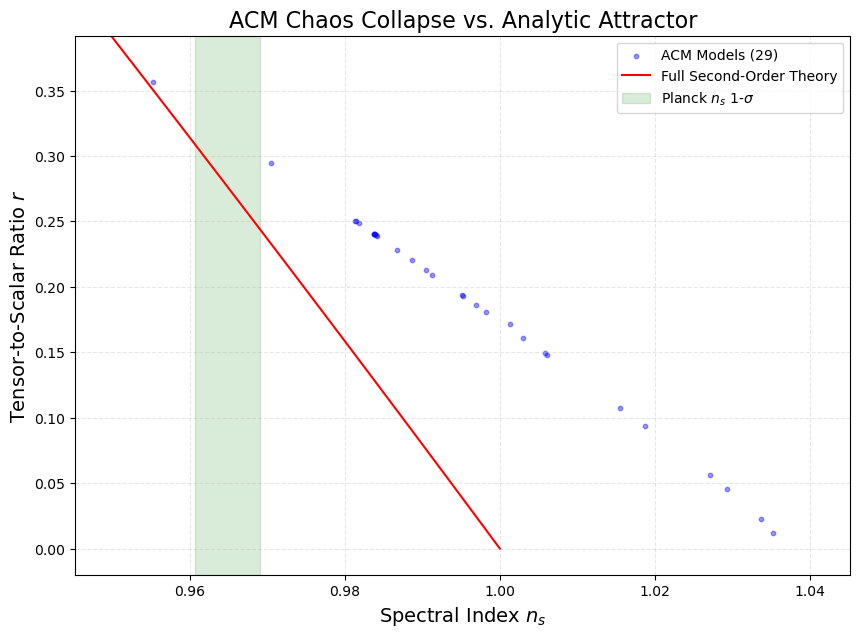

In [1]:
import sys
import os
import numpy as np

# Adds the parent directory to the python path
sys.path.append(os.path.abspath('../'))

from src.physics.dynamics import HSRSolver
from src.physics.simulation import MonteCarloRunner
#from src.visualization.plots import plot_acm_comparison
from src.visualization.plots import plot_acm_vs_attractor


# Setup
solver = HSRSolver()
runner = MonteCarloRunner(solver)

# Run Simulation
results = runner.run_batch_acm(n_sims=5000, n_obs=55)

# Visualize results against theoretical attractor

# This cell will only work if Cell 2 finished successfully
if 'results' in locals():
    plot_acm_vs_attractor(results)
else:
    print("Variable 'results' still not found. Please run the simulation cell.")

Stability Matrix Eigenvalues: [-6.85271795e-01+0.j  2.00000000e-09+0.j  5.00000001e-10+0.j]
System is STABLE if Re(eigs) < 0: False


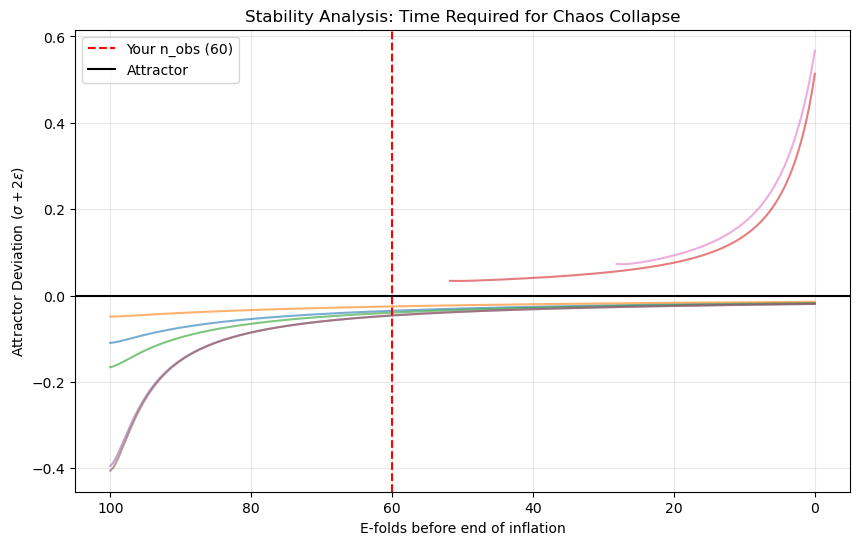

Running Guided ACM: 100%|██████████| 1000/1000 [01:03<00:00, 15.82it/s]


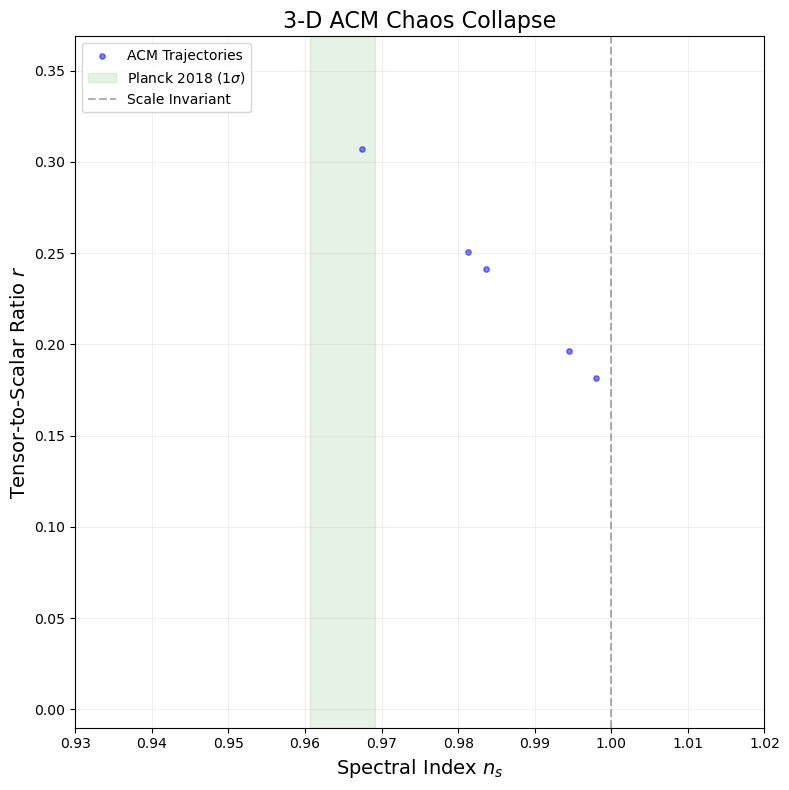

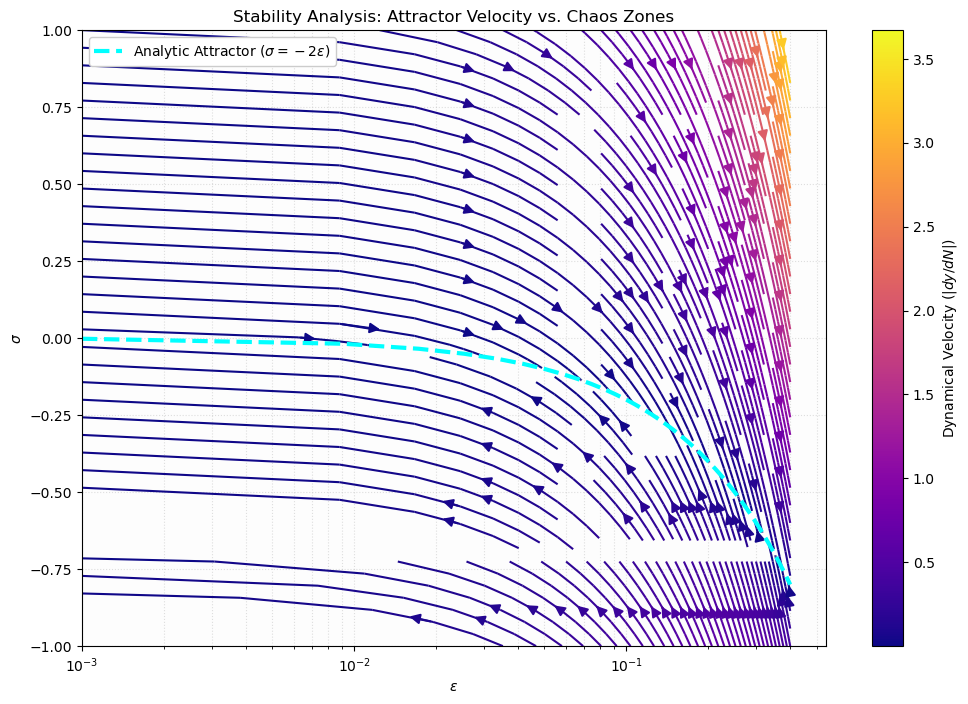

In [22]:
import sys
import os
import numpy as np

# Adds the parent directory to the python path
sys.path.append(os.path.abspath('../'))

from src.visualization.plots import plot_chaos_collapse, plot_phase_space_flow, plot_relaxation_time, plot_stability_velocity

# 1. Setup
solver = HSRSolver(c_const=0.08145)
runner = MonteCarloRunner(solver)

# 2. Stability Analysis (Math)
f_point, eigs = runner.run_stability_analysis()
print(f"Stability Matrix Eigenvalues: {eigs}")
print(f"System is STABLE if Re(eigs) < 0: {np.all(np.real(eigs) < 0)}")

# # 3. Stability Analysis (Visual Flow)
# # This explains WHERE the points are going
# plot_phase_space_flow(solver)

# 4. Stability Analysis (Time)
# This explains WHY you need N=60 vs N=55
plot_relaxation_time(runner)

# 5. Resulting Observables
data = runner.run_batch_acm(n_sims=1000, n_obs=55)
plot_chaos_collapse(data)

#6. Run stability and velocity 
plot_stability_velocity(solver)


Text(0.5, 1.0, 'ACM Phase Flow at fixed $\\epsilon$')

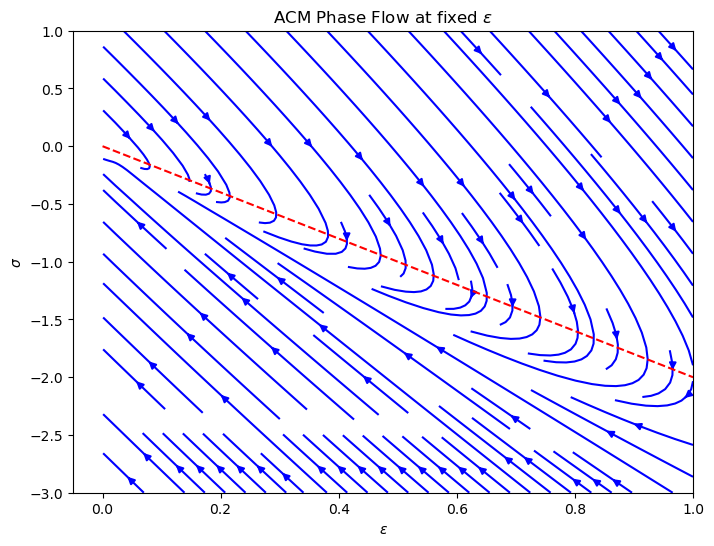

In [ ]:
# We create a 2D slice of the vector field at a fixed epsilon
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

# Use your existing derivative function
E, S = np.meshgrid(np.linspace(0.001, 1.0, 20), np.linspace(-3, 1, 20))
U, V = np.zeros_like(E), np.zeros_like(S)

for i in range(E.shape[0]):
    for j in range(E.shape[1]):
        # [epsilon, sigma, lambda_2]
        res = solver.get_derivatives_acm(0, [E[i,j], S[i,j], 0.0]) 
        U[i,j], V[i,j] = res[0], res[1]

ax.streamplot(E, S, U, V, color='blue')
ax.plot(np.linspace(0, 1, 10), -2*np.linspace(0, 1, 10), 'r--') # The Attractor
plt.xlabel(r'$\epsilon$'); plt.ylabel(r'$\sigma$'); plt.title(r'ACM Phase Flow at fixed $\epsilon$')

Text(0.5, 1.0, 'Constraint Satisfaction (Residual Error)')

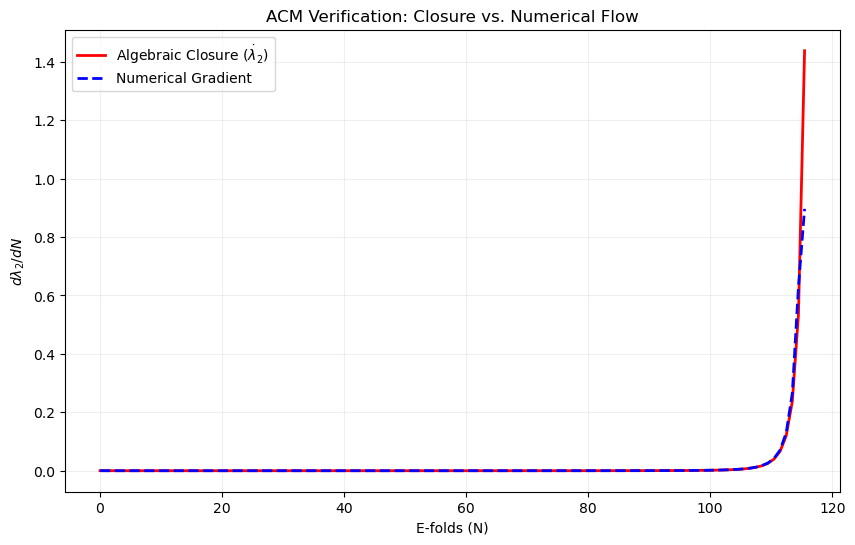

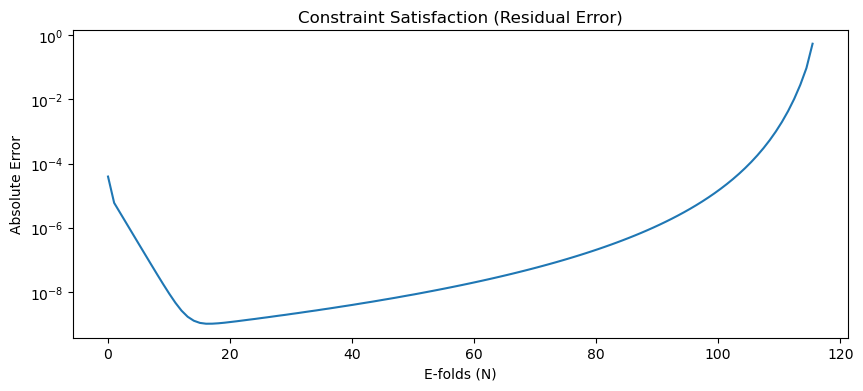

In [15]:
# 1. Setup initial conditions
# [epsilon, sigma, lambda_2]
y0 = [0.01, -0.02, 0.0] 

# 2. Run the trajectory using your specific instance name
# Replace 'my_model' with whatever you named your class instance
sol = runner.run_trajectory(y0, method='acm', n_max=250)

# 3. Calculate Algebraic lambda_3 and Numerical dL2/dN
lambda_3_vals = []
for i in range(len(sol.t)):
    y_state = sol.y[:, i]
    # Call the derivative function directly from the instance
    # We take the 3rd element ([2]) because that's d_lambda2_dN
    # which your code defines as (0.5 * sigma * lambda_2 + lambda_3_closed)
    derivatives = solver.get_derivatives_acm(sol.t[i], y_state)
    lambda_3_vals.append(derivatives[2]) 

# 4. Numerical derivative for the 'Actual' behavior
d_lambda2_dN_num = np.gradient(sol.y[2], sol.t)

# 5. Plotting the Verification
plt.figure(figsize=(10, 6))
plt.plot(sol.t, lambda_3_vals, 'r-', lw=2, label=r'Algebraic Closure ($\dot{\lambda}_2$)')
plt.plot(sol.t, d_lambda2_dN_num, 'b--', lw=2, label=r'Numerical Gradient')
plt.ylabel(r'$d\lambda_2 / dN$')
plt.xlabel('E-folds (N)')
plt.title('ACM Verification: Closure vs. Numerical Flow')
plt.legend()
plt.grid(alpha=0.2)
residual = np.array(lambda_3_vals) - d_lambda2_dN_num

plt.figure(figsize=(10, 4))
plt.plot(sol.t, np.abs(residual))
plt.yscale('log') # Log scale is best for checking stability
plt.ylabel('Absolute Error')
plt.xlabel('E-folds (N)')
plt.title('Constraint Satisfaction (Residual Error)')

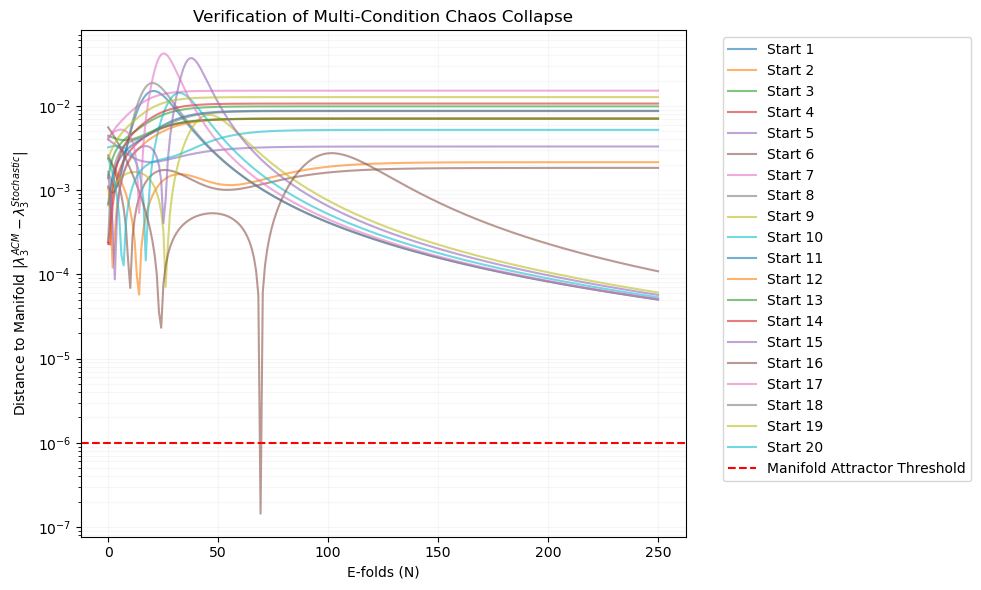

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. SETUP PARAMETERS ---
num_universes = 20  # Number of random starts to test
n_folds = 250      # Max integration length
threshold = 1e-6   # The "Analytic Floor"

plt.figure(figsize=(10, 6))

# --- 2. BATCH LOOP ---
for i in range(num_universes):
    # Generate random initial conditions [epsilon, sigma, lambda2, lambda3]
    # We create "Chaos" by varying the start parameters significantly
    y0_stoch = [
        0.01 + np.random.uniform(0, 0.02),   # Random epsilon
        -0.05 + np.random.uniform(-0.1, 0.1), # Random sigma
        np.random.uniform(-0.005, 0.005),    # Random lambda2
        np.random.uniform(-0.001, 0.001)     # Random lambda3
    ]
    
    # Run the STOCHASTIC (non-constrained) trajectory
    # Replace 'runner' with your actual instance name
    sol = runner.run_trajectory(y0_stoch, method='stochastic', n_max=n_folds)
    
    l3_closure_prediction = []
    l3_actual_numerical = sol.y[3] # Extract the floating lambda3 from the run
    
    # --- 3. THE ANALYTIC CHECK ---
    # We step through the chaotic path and calculate the "Ideal" ACM lambda3
    for j in range(len(sol.t)):
        eps, sig, l2 = sol.y[0, j], sol.y[1, j], sol.y[2, j]
        
        # Access your model's derived constants alpha, beta, delta
        # (These are calculated inside your class based on your constant C)
        a = solver.alpha
        b = solver.beta
        d = solver.delta
        
        # Core HSR physics for the closure
        d_eps = eps * (sig + 2 * eps)
        d_sig = -eps * (5 * sig + 12 * eps) + 2 * l2
        
        # ACM Closure Algebra
        R_y = sig + b * eps**2 + d * sig * eps + a * l2
        G_y = (d_sig + 2 * b * eps * d_eps + 
               d * (sig * d_eps + eps * d_sig) + 
               a * 0.5 * sig * l2)
        
        # This is the lambda3 the ACM WOULD have chosen
        l3_ideal = (1.0 / a) * (0.5 * R_y**2 - G_y)
        l3_closure_prediction.append(l3_ideal)
    
    # Calculate absolute distance from the manifold
    residual = np.abs(np.array(l3_closure_prediction) - l3_actual_numerical)
    
    # --- 4. PLOTTING ---
    plt.plot(sol.t, residual, alpha=0.6, label=f'Start {i+1}')

# Finalizing the plot
plt.yscale('log')
plt.axhline(threshold, color='red', linestyle='--', label='Manifold Attractor Threshold')
plt.ylabel(r'Distance to Manifold $|\lambda_3^{ACM} - \lambda_3^{Stochastic}|$')
plt.xlabel('E-folds (N)')
plt.title('Verification of Multi-Condition Chaos Collapse')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which="both", ls="-", alpha=0.1)
plt.tight_layout()
plt.show()